In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

import pmdarima as pm
from pmdarima.arima import auto_arima
import re
from statsmodels.tsa.stattools import adfuller


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#from pandas_datareader import data as pdr
import datetime as dt

import yfinance as yf

In [3]:
#legacy code from LSTM to retrieve prices
class price_volume_data:
    """A class for retrieving and analyzing price and volume data."""
    def __init__(self, tickers, start_date, end_date):
        """
        Initializes a new instance of the price_volume_data class.

        Args:
            tickers (list): A list of tickers for the assets to retrieve data for.
            start_date (str): The start date for the data retrieval (format: 'YYYY-MM-DD').
            end_date (str): The end date for the data retrieval (format: 'YYYY-MM-DD').
        """
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.pv = self.__retrieve_data__()
        #self.lp, self.ret = self.__get_daily_returns__() #didn't need daily returns
        
    def __retrieve_data__(self):
        """
        Retrieves price and volume data for the given tickers from Yahoo Finance API.

        Returns:
            dict: A dictionary containing the price and volume data for each ticker.
        """

        data, failed = {}, []
        for ticker in self.tickers:
            try:
                df = yf.Ticker(ticker).history(start = self.start_date, end = self.end_date)
                
                data[ticker] = df
                
            except:
                failed.append(ticker)
                
        if failed:
            print('Tickers failed to extract: ', failed)
        
        return data
    
    def __get_daily_returns__(self):
        """
        Computes daily returns for the retrieved price data.

        Returns:
            pd.DataFrame: A DataFrame containing the daily price data.
            pd.DataFrame: A DataFrame containing the daily price returns.
        """
        df = pd.DataFrame()
        
        for ticker in self.pv:
            if df.empty:
                df = pd.DataFrame(self.pv[ticker]['Close'].copy())
            else:
                df = df.merge(self.pv[ticker]['Close'], how='outer',left_index=True, right_index=True)

        df.columns = self.tickers
        df = df.fillna(method = 'ffill')
        
        return df, df/df.shift(1) - 1
    
    def get_info(self, ticker = None):
        """
        Prints information about the price and volume data for the specified ticker.
        If no ticker is provided, prints information for all tickers.

        Args:
            ticker (str, optional): The ticker symbol for the asset. Defaults to None.
        """
        if ticker:
            self.pv[ticker].info()
        
        else:
            for ticker in self.pv:
                self.pv[ticker].info()
                
        return None
    
    def plot_price_trends(self, normalize = True, reference = -1):
        """
        Plots the close prices of selected assets over time.

        Args:
            normalize (bool, optional): Indicates whether to normalize the prices. Defaults to True.
            reference (int, optional): Reference point for normalization. Defaults to -1.
        """
        f, ax = plt.subplots(1,1,figsize=(12,5))
        # plot prices
        for key in self.pv:
            last_price = self.pv[key].loc[:, 'Close'].copy()
            if normalize:
                if reference == -1:
                    last_price /= last_price.iloc[0]
                elif reference == 0:
                    midpt = int(last_price.shape[0]/2)
                    last_price /= last_price.iloc[midpt]
                else:
                    last_price /= last_price.iloc[-1]
            last_price.plot(ax = ax, label = key)
        
        ax.title.set_text('Close Prices of selected assets')
        ax.set(ylabel = 'Normalized Price to start of observation')
        ax.legend()
        plt.show()
        
    def plot_corr(self, method='pearson', output = False, series = 'price'):
        """
        Plots the correlation matrix between asset prices or returns.

        Args:
            method (str, optional): The correlation method to use. Defaults to 'pearson'.
            output (bool, optional): Indicates whether to return the correlation matrix. Defaults to False.
            series (str, optional): Indicates whether to use 'price' or 'returns'. Defaults to 'price'.

        Returns:
            pd.DataFrame or None: The correlation matrix if output=True, None otherwise.
        """
        corr_matrix = self.lp.corr(method) if series == 'price' else self.ret.corr(method)
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        
        f, ax = plt.subplots(figsize=(5, 5))
        sns.heatmap(corr_matrix, mask=mask, vmin=-1, vmax=1, annot=True)
        
        return corr_matrix if output else None
        
        
    def get_technical_indicators(self, indicators = None, normalize = True):
        """
        Computes and adds various technical indicators to the price data.

        Args:
            indicators (list, optional): A list of tuples specifying the indicators and their parameters.
                Defaults to None.
            normalize (bool, optional): Indicates whether to normalize the indicator values. Defaults to True.
        """
        if not indicators:
            indicators = [('SMA', 5), ('SMA', 14), ('ATR', 5), ('ATR', 14), ('ADX', 5),
                         ('ADX', 14), ('RSI', 5), ('RSI', 14), ('MACD', None), ('BBANDS', None)]
        
        for data in self.pv:
            df = self.pv[data]
            for indicator, param in indicators:
                
                if indicator == 'SMA':
                    df[f'{indicator}_{param}'] = talib.SMA(df['Close'], param)

                elif indicator == 'ATR':
                    df[f'{indicator}_{param}'] = talib.ATR(df['High'], df['Low'], df['Close'], param) 
                    
                elif indicator == 'ADX':
                    df[f'{indicator}_{param}'] = talib.ADX(df['High'], df['Low'], df['Close'], param) 
                    
                elif indicator == 'RSI':
                    df[f'{indicator}_{param}'] = talib.RSI(df['Close'], param) 
                    
                elif indicator == 'MACD':
                    df[f'{indicator}'], df[f'{indicator}_signal'], _ = talib.MACD(df['Close']) 
                    
                    
                elif indicator == 'BBANDS':
                    df[f'{indicator}_upp'], df[f'{indicator}_mid'], df[f'{indicator}_low'] = talib.BBANDS(df['Close'])
                    
                    
                else:
                    print('Indicators not built into the class. Please run TALIB manually!')
            
            df = df.replace([np.inf, -np.inf], np.nan, inplace = True)
            
        return None              

In [12]:
sheet_name = ['20220526','20220825','20221124','20230223','20230525']
symbols = pd.read_excel("target_stock_universe.xlsx", sheet_name = sheet_name[4]) # change here to get the other sheet
symbols['Ticker_Symbol'] = symbols['Ticker'].str.split().str[0]+".L"
# symbols = symbols[symbols['Ticker_Symbol']!='HSV.L']
# symbols = symbols[symbols['Ticker_Symbol']!='HBR.L']
# symbols = symbols[symbols['Ticker_Symbol']!='TW/.L']
symbols = symbols[symbols['Ticker_Symbol']!='MDC.L']
symbols = symbols[symbols['Ticker_Symbol']!='HL/.L']


symbols_short = symbols['Ticker_Symbol']
symbols_short

0      BEZ.L
1      PSN.L
2      HSX.L
4      RS1.L
5      UTG.L
6     JMAT.L
7     BLND.L
8     FRAS.L
9     OCDO.L
10     CCL.L
11     IMI.L
12    INVP.L
13     HIK.L
14     ICP.L
15    DPLM.L
16     SXS.L
17    HWDN.L
18     EZJ.L
20     DPH.L
21    INCH.L
22     MKS.L
23    TATE.L
24     GAW.L
25    WIZZ.L
26     ITV.L
27     BWY.L
28     IGG.L
29     ROR.L
30     TUI.L
31     GRG.L
32    BBOX.L
33     VTY.L
34     CCC.L
Name: Ticker_Symbol, dtype: object

In [13]:
symbols_ = symbols.set_index("Ticker_Symbol")

In [14]:
data = price_volume_data(symbols_short.to_list(),'2018-05-26', '2023-05-30')
data.pv

{'BEZ.L':                                  Open        High         Low       Close  \
 Date                                                                        
 2018-05-29 00:00:00+01:00  549.611578  551.894018  538.655866  540.025330   
 2018-05-30 00:00:00+01:00  538.199347  543.220715  536.373395  542.307739   
 2018-05-31 00:00:00+01:00  543.220728  548.698584  542.307752  545.959656   
 2018-06-01 00:00:00+01:00  549.155054  556.915350  549.155054  551.893982   
 2018-06-04 00:00:00+01:00  554.176459  557.828363  543.677234  553.719971   
 ...                               ...         ...         ...         ...   
 2023-05-22 00:00:00+01:00  622.500000  625.000000  617.500000  619.000000   
 2023-05-23 00:00:00+01:00  615.500000  624.549988  612.702026  619.000000   
 2023-05-24 00:00:00+01:00  614.000000  616.500000  601.000000  603.500000   
 2023-05-25 00:00:00+01:00  603.000000  610.500000  598.500000  606.500000   
 2023-05-26 00:00:00+01:00  614.000000  619.000000  599

In [15]:
#data wrangling
#objective is to have a dataframe of close prices. columns = stocks and rows = price observations (time series)

df = data.pv[symbols_short[0]]["Close"]
for stock in symbols_short[1:]:
    
    df = pd.concat([df, data.pv[stock]["Close"]], axis = 1)

df.columns = symbols_short
df.index = pd.to_datetime(df.index.date)

In [16]:
df

Ticker_Symbol,BEZ.L,PSN.L,HSX.L,RS1.L,UTG.L,JMAT.L,BLND.L,FRAS.L,OCDO.L,CCL.L,...,WIZZ.L,ITV.L,BWY.L,IGG.L,ROR.L,TUI.L,GRG.L,BBOX.L,VTY.L,CCC.L
2018-05-29,540.025330,1658.104248,1311.466553,627.521240,723.521729,2851.176758,524.886780,411.200012,874.400024,4445.595703,...,3402.0,121.480881,2620.455811,570.207397,301.034546,15450.556641,906.265503,116.172539,925.379150,1161.860840
2018-05-30,542.307739,1666.350830,1315.835083,625.383789,727.841187,2866.365234,524.886780,407.500000,887.599976,4446.512695,...,3325.0,121.929268,2628.457520,570.535828,296.529663,15590.360352,923.494812,117.035385,925.745789,1154.965698
2018-05-31,545.959656,1668.117798,1312.340332,626.808777,733.888550,2964.245605,527.688477,406.700012,898.000000,4441.004395,...,3402.0,121.518250,2626.857422,567.908203,294.763000,15757.220703,909.711365,117.662949,923.545898,1152.081055
2018-06-01,551.893982,1687.555542,1332.436035,634.468018,726.977234,3084.063965,530.179260,410.100006,872.200012,4416.215332,...,3512.0,122.863449,2657.262451,571.192688,301.122894,15712.125000,912.295715,117.976692,929.778625,1153.829224
2018-06-04,553.719971,1679.309204,1338.552002,640.345947,730.864868,3190.382080,537.183838,414.500000,879.400024,4474.057129,...,3519.0,124.246056,2661.263184,574.805847,301.299561,16018.789062,900.235229,117.819847,923.912537,1153.829224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-22,619.000000,1283.367188,1156.726196,838.092834,902.833923,1845.725098,344.447815,748.500000,403.399994,787.799988,...,2979.0,72.614403,2412.448486,668.108154,334.267334,530.799988,2696.218018,141.735245,813.000000,2381.957275
2023-05-23,619.000000,1261.781494,1162.668335,779.520691,909.251038,1851.056763,353.435944,717.000000,402.600006,798.599976,...,2917.0,72.633896,2379.105713,666.679565,328.716034,548.200012,2668.401367,144.500809,790.000000,2312.014160
2023-05-24,603.500000,1192.118652,1140.880615,775.196594,883.089050,1804.041138,344.641113,705.500000,411.799988,743.200012,...,2850.0,70.899414,2283.000000,654.774597,323.561249,528.400024,2636.611084,139.265991,751.500000,2263.442383
2023-05-25,606.500000,1196.533936,1151.774536,784.041382,874.697510,1745.877563,340.678619,683.500000,402.899994,778.400024,...,2900.0,70.587593,2284.000000,648.107788,319.596039,528.400024,2640.584717,136.006561,751.000000,2240.127686


In [17]:
file = pd.read_csv("prediction_result_3days_200622.csv")
file = file.set_index("Unnamed: 0")

In [18]:
file

,Actual Price,Predicted Price,MSE,MAE,R2,Market Share,final_marketcap
Unnamed: 0,,,,,,,
CCL.L,1011.500000,[1102.1017],0.004354,0.065982,1,146260000,"147,941,990,000.00"
PNN.L,921.890503,[978.6994],0.094318,0.307112,1,261327008,240914886834.23047
IGG.L,652.198731,[628.6662],0.035130,0.187431,1,395398016,257878084065.0625
ITV.L,65.962585,[66.964294],0.002242,0.047346,1,4034409984,266120113306.78125
INVP.L,433.472778,[401.9024],0.167294,0.409016,1,645161984,"279,660,157,671.13"
EMG.L,240.397629,[223.5084],0.285668,0.534479,1,1199859968,288443491180.2617
TATE.L,722.515076,[747.0776],0.113386,0.336728,1,401665984,290209728829.28516
RSW.L,4005.439697,[3899.5273],0.019304,0.138940,1,72788496,291549931382.66016
IDS.L,313.700653,[276.65097],0.108747,0.329769,1,956193024,299958376095.6797


In [19]:
########################################

In [20]:
df_standardised = df.iloc[:-3].apply(lambda price: (price.iloc[:-3] - price.iloc[:-3].mean())/price.iloc[:-3].std())
df_standardised




Ticker_Symbol,BEZ.L,PSN.L,HSX.L,RS1.L,UTG.L,JMAT.L,BLND.L,FRAS.L,OCDO.L,CCL.L,...,WIZZ.L,ITV.L,BWY.L,IGG.L,ROR.L,TUI.L,GRG.L,BBOX.L,VTY.L,CCC.L
2018-05-29,0.767311,-0.192399,0.968744,-0.714574,-1.572162,1.096866,1.472940,-0.414120,-0.826574,1.843122,...,-0.072577,1.490415,0.332515,-0.303593,0.397748,2.604149,-1.731692,-0.866318,0.611717,-1.135077
2018-05-30,0.790511,-0.172597,0.985186,-0.725119,-1.538372,1.131706,1.472940,-0.432879,-0.804548,1.843829,...,-0.156681,1.511366,0.351431,-0.300994,0.273419,2.639896,-1.701075,-0.841630,0.613839,-1.146914
2018-05-31,0.827632,-0.168354,0.972032,-0.718089,-1.491066,1.356228,1.518936,-0.436935,-0.787195,1.839578,...,-0.072577,1.492161,0.347649,-0.321790,0.224661,2.682560,-1.725569,-0.823674,0.601107,-1.151866
2018-06-01,0.887952,-0.121678,1.047671,-0.680305,-1.545131,1.631072,1.559827,-0.419697,-0.830245,1.820447,...,0.047571,1.555014,0.419529,-0.295795,0.400186,2.671030,-1.720976,-0.814698,0.637178,-1.148865
2018-06-04,0.906512,-0.141480,1.070691,-0.651308,-1.514719,1.874949,1.674821,-0.397389,-0.818231,1.865087,...,0.055217,1.619614,0.428987,-0.267200,0.405062,2.749441,-1.742409,-0.819185,0.603229,-1.148865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-12,1.417591,-1.022751,0.393769,0.343595,-0.188768,-1.126095,-1.256083,1.440472,-1.549076,-1.046929,...,-0.501834,-0.790980,-0.196326,0.508912,1.074174,-1.215800,1.692820,-0.072755,-0.189131,0.899459
2023-05-15,1.524319,-1.025107,0.393769,0.346503,-0.088370,-1.155003,-1.192617,1.458217,-1.566430,-1.032575,...,-0.484358,-0.773679,-0.154595,0.508912,1.063231,-1.211914,1.678696,-0.013409,-0.102321,0.932812
2023-05-16,1.483661,-1.013327,0.375131,0.291236,-0.126985,-1.202811,-1.148191,1.389772,-1.594462,-1.020227,...,-0.425376,-0.796443,-0.098954,0.516449,1.079646,-1.211198,1.516276,-0.004931,-0.018404,0.949490
2023-05-17,1.422673,-1.065161,0.345310,0.290266,-0.138569,-1.242836,-1.487733,1.389772,-1.600970,-0.997229,...,-0.339087,-0.808281,-0.168506,0.441073,1.123420,-1.208437,1.565708,-0.021887,-0.032873,0.932812


In [21]:
#actual price is the price 1 day after prediction

actual_price_ls = []
ticker_mean_dict = {}
ticker_std_dict = {}
for column in df.columns:
    ticker_mean_dict[column] = df[column].iloc[:-3].mean()
    ticker_std_dict[column] = df[column].iloc[:-3].std()
    actual_price_ls.append((df[column].iloc[-1] - ticker_mean_dict[column]) / ticker_std_dict[column])
actual_price_df = pd.DataFrame(index = df.columns)
actual_price_df["actual_price"] = actual_price_ls


In [22]:
#FINAL

"""
ARIMA & NAIVE


#inputs = df, dataframe of close prices.
#outputs = dataframe of (params_dict). contains the optimized params (p, d, q) using auto-arima
        # = plots of original time series
        # = plots of results.summary() of fitting optimized params into ARIMA(p,d,q)
        # = plots of residuals
        # = plots of forecast (3 days look-ahead) 
"""


import re
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pmdarima.arima import auto_arima

def find_differencing_order(ts, look_forward):
    d = 0
                                                    
    p_value = adfuller(ts.iloc[:-(look_forward)].dropna())[1]
    while p_value > 0.05:  # Adjust the significance level as needed
        ts_interm = ts.diff().dropna()
        d += 1
        p_value = adfuller(ts_interm)[1]
    return d




####creating a function for ARIMA prediction

def get_ARIMA_PRED(standardised_df, look_forward):
    dict_ = {}
    models = {}  
    results = {}
    
    for column in standardised_df.columns:

        differencing_order = find_differencing_order(standardised_df[column], look_forward)

        best_model = auto_arima(standardised_df[column].iloc[:-(look_forward)].dropna(), start_p=0, d=differencing_order, start_q=0,
                                max_p=4, max_q=4,
                                seasonal=True, trace=True,
                                stepwise=True, suppress_warnings=True, error_action='ignore')



        p_optimal = best_model.get_params()['order'][0]
        d_optimal = best_model.get_params()['order'][1]
        q_optimal = best_model.get_params()['order'][2]

        model_name = re.sub(r'\W+', '_', f'{column}').lower()
        models[model_name] = sm.tsa.ARIMA(standardised_df[column].iloc[:-(look_forward)].dropna(), order=(p_optimal, d_optimal, q_optimal))
        results[model_name] = models[model_name].fit()

        # Print model summary
        print(results[model_name].summary())

        # Plot the residuals to check for randomness
        # Residuals should show no predictability in variance and have a mean of 0
        residuals = results[model_name].resid
        plt.figure(figsize=(12, 6))
        plt.plot(residuals)
        plt.title('Residuals')
        plt.xlabel('Date')
        plt.ylabel('Residual Value')
        plt.show()

        # Forecast future values
        forecast_steps = look_forward  # Number of time steps to forecast ahead
        forecast = results[model_name].forecast(steps=forecast_steps)

        dict_[column] = {
            "optimal_p": p_optimal,
            "optimal_q": q_optimal,
            "optimal_d": d_optimal,
            "ARIMA_prediction": forecast.iloc[look_forward-1],  # because forecast is a Series with indexing that starts from 0, therefore we subtract 1
        }

    # Create a DataFrame to store the model information
    dict_df = pd.DataFrame(dict_)
    
    return dict_df


#import the price data for the remaining target universe at different rank dates

#dictionary to store DataFrames
dfs_target_uni = {}
params_dict_ = {}

# Loop through each sheet name and read the corresponding sheet into a DataFrame
for date in sheet_name:
    dfs_target_uni[f'df_{sheet_name}'] = pd.read_excel("target_stock_universe.xlsx", sheet_name=date)
    
    params_dict_[date] = get_ARIMA_PRED(df_standardised, 3)
    

sheet_name = ['20220524','20220823','20221122','20230221','20230523']
symbols = pd.read_excel("target_stock_universe.xlsx", sheet_name = sheet_name[0]) # change here to get the other sheet
symbols['Ticker_Symbol'] = symbols['Ticker'].str.split().str[0]+".L"
symbols = symbols[symbols['Ticker_Symbol']!='HSV.L']
symbols = symbols[symbols['Ticker_Symbol']!='HBR.L']


symbols_short = symbols['Ticker_Symbol']
symbols_short

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2304.005, Time=4.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2302.824, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2302.825, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2305.955, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2300.825, Time=0.36 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 5.196 seconds
                               SARIMAX Results                                
Dep. Variable:                  BEZ.L   No. Observations:                 1253
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1153.978
Date:                Mon, 30 Oct 2023   AIC                          -2305.955
Time:                        17:07:40   BIC                          -2300.823
Sample:                             0   HQIC                         -2304.026
                               - 1253                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


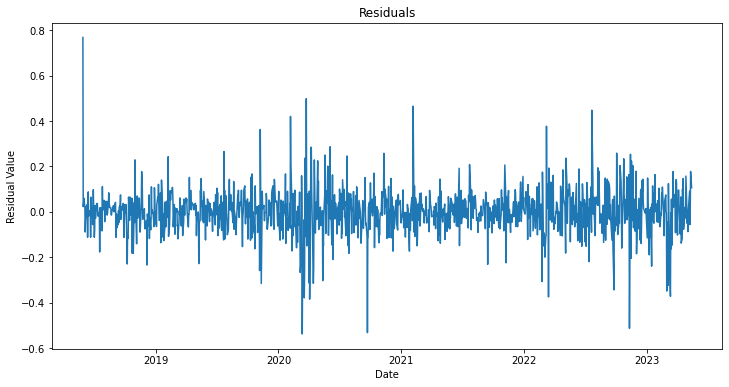

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2326.684, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2325.312, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2325.280, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2328.623, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2324.566, Time=0.40 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.366 seconds
                               SARIMAX Results                                
Dep. Variable:                  PSN.L   No. Observations:                 1253
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1165.312
Date:                Mon, 30 Oct 2023   AIC                          -2328.623
Time:                        17:07:42   BIC                          -2323.491
Sample:                             0   HQIC                         -2326.694
                               - 1253                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


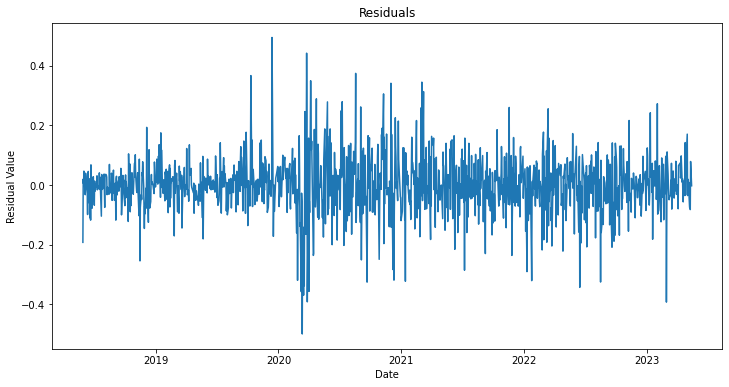

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2866.673, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2866.248, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2866.457, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2868.628, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2867.531, Time=0.93 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.661 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  HSX.L   No. Observations:                 1253
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1435.314
Date:                Mon, 30 Oct 2023   AIC                          -2868.628
Time:                        17:07:44   BIC                          -2863.495
Sample:                             0   HQIC                         -2866.699
                               - 1253                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0059   7.26e-05     81.476      0.000       0.006       0.006
Ljung-Box (L1) (Q):                   1.58   Jarque-Bera (JB):             19345.50
Prob(Q):                              0.21   Pr

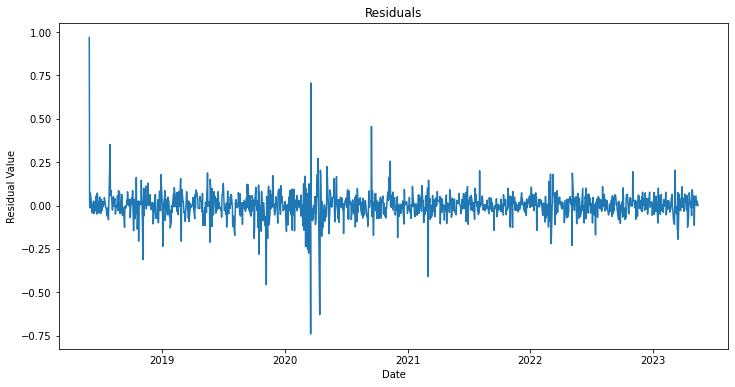

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2999.910, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3000.041, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2999.983, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3001.736, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2998.070, Time=0.39 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.554 seconds
                               SARIMAX Results                                
Dep. Variable:                  RS1.L   No. Observations:                 1243
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1501.868
Date:                Mon, 30 Oct 2023   AIC                          -3001.736
Time:                        17:07:47   BIC                          -2996.611
Sample:                             0   HQIC                         -2999.809
                               - 1243                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


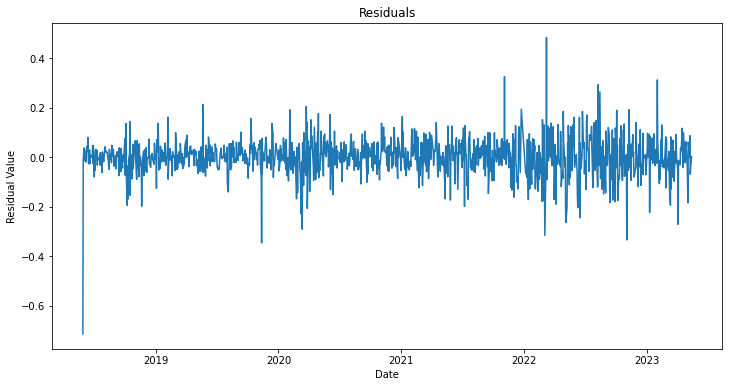

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3561.744, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2040.167, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3559.744, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1451.743, Time=0.47 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1451.632, Time=2.24 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-1453.647, Time=0.47 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=986.581, Time=0.77 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-1452.758, Time=1.52 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-1453.472, Time=0.44 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=317.961, Time=0.69 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-1451.606, Time=1.42 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1455.632, Time=0.49 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=984.581, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[0]           

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  UTG.L   No. Observations:                 1253
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 731.856
Date:                Mon, 30 Oct 2023   AIC                          -1453.712
Time:                        17:08:01   BIC                          -1428.045
Sample:                             0   HQIC                         -1444.064
                               - 1253                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0983      0.333     -0.295      0.768      -0.750       0.554
ar.L1          0.9883      0.004    239.439      0.000       0.980       0.996
ma.L1          0.0872      0.020      4.312      0.0

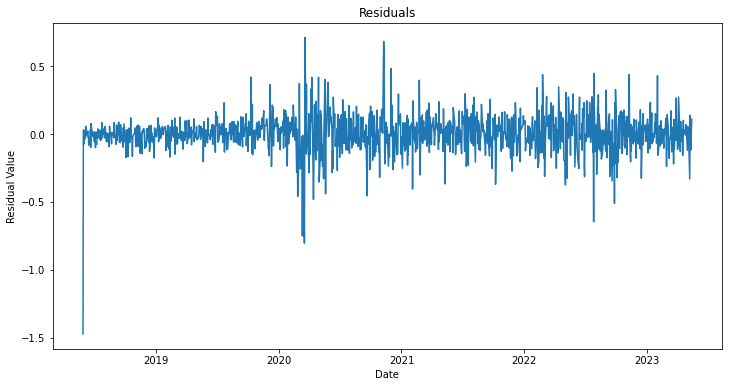

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1950.121, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1949.540, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1949.596, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1951.788, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1946.594, Time=1.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.147 seconds
                               SARIMAX Results                                
Dep. Variable:                 JMAT.L   No. Observations:                 1248
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 976.894
Date:                Mon, 30 Oct 2023   AIC                          -1951.788
Time:                        17:08:04   BIC                          -1946.659
Sample:                             0   HQIC                         -1949.860
                               - 1248                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


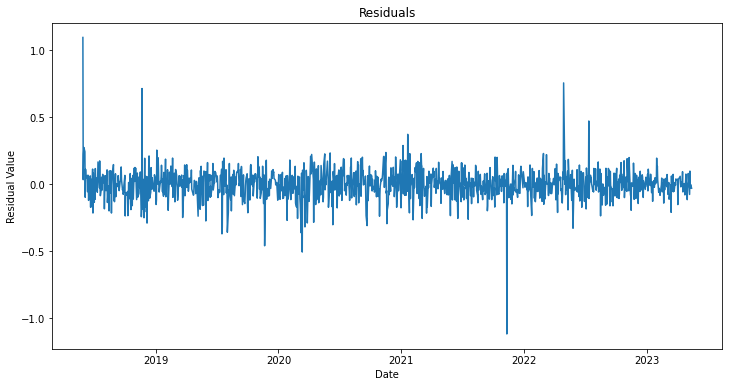

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1445.338, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1443.371, Time=0.36 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1443.370, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1447.030, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1441.370, Time=0.25 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.368 seconds
                               SARIMAX Results                                
Dep. Variable:                 BLND.L   No. Observations:                 1253
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 724.515
Date:                Mon, 30 Oct 2023   AIC                          -1447.030
Time:                        17:08:06   BIC                          -1441.897
Sample:                             0   HQIC                         -1445.100
                               - 1253                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


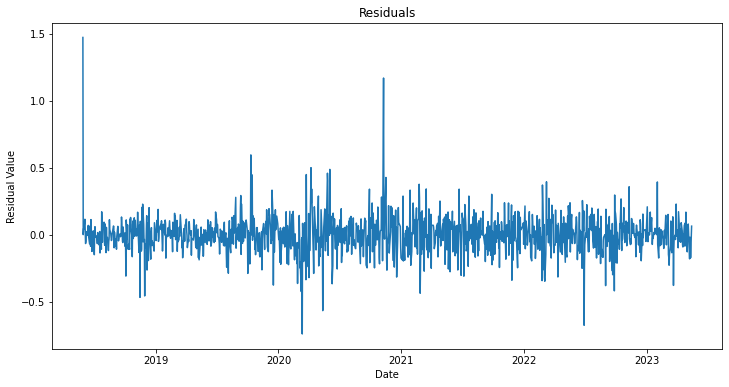

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3201.790, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3200.781, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3200.742, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3203.171, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3201.914, Time=1.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.012 seconds
                               SARIMAX Results                                
Dep. Variable:                 FRAS.L   No. Observations:                 1253
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1602.585
Date:                Mon, 30 Oct 2023   AIC                          -3203.171
Time:                        17:08:08   BIC                          -3198.038
Sample:                             0   HQIC                         -3201.242
                               - 1253                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


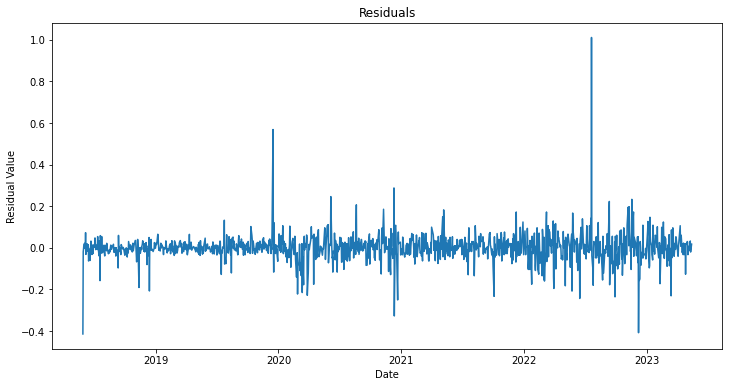

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3085.800, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3084.183, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3084.195, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3087.712, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3082.287, Time=0.66 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.212 seconds
                               SARIMAX Results                                
Dep. Variable:                 OCDO.L   No. Observations:                 1252
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1544.856
Date:                Mon, 30 Oct 2023   AIC                          -3087.712
Time:                        17:08:10   BIC                          -3082.580
Sample:                             0   HQIC                         -3085.783
                               - 1252                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


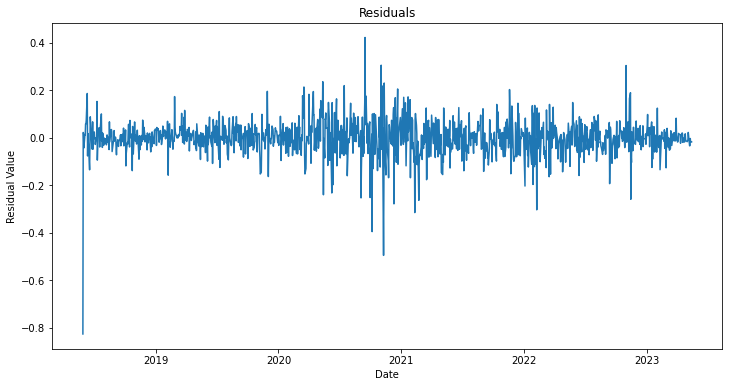

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3839.456, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3838.631, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3838.527, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3839.028, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3836.466, Time=0.37 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.170 seconds
                               SARIMAX Results                                
Dep. Variable:                  CCL.L   No. Observations:                 1253
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1920.514
Date:                Mon, 30 Oct 2023   AIC                          -3839.028
Time:                        17:08:12   BIC                          -3833.896
Sample:                             0   HQIC                         -3837.099
                               - 1253                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


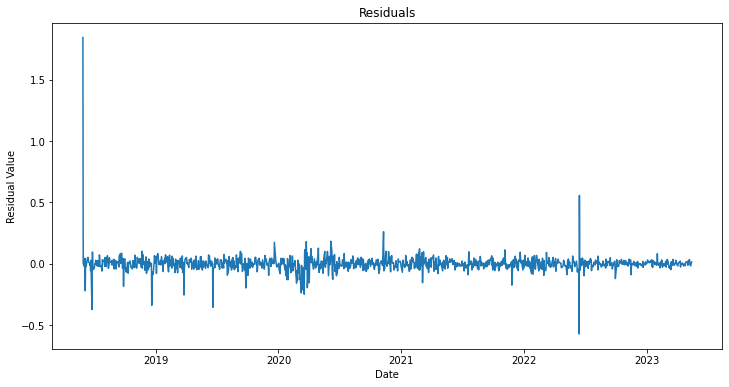

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3022.415, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3020.865, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3020.860, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3023.713, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3018.793, Time=0.29 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.919 seconds
                               SARIMAX Results                                
Dep. Variable:                  IMI.L   No. Observations:                 1253
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1512.857
Date:                Mon, 30 Oct 2023   AIC                          -3023.713
Time:                        17:08:13   BIC                          -3018.581
Sample:                             0   HQIC                         -3021.784
                               - 1253                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


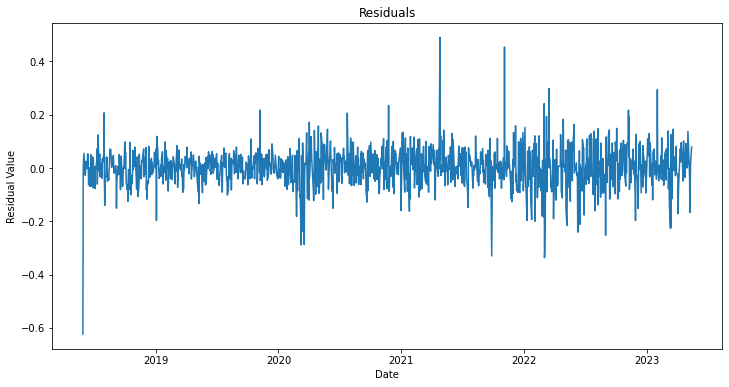

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3391.830, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3390.524, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3390.423, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3393.598, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3392.649, Time=0.71 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.569 seconds
                               SARIMAX Results                                
Dep. Variable:                 INVP.L   No. Observations:                 1253
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1697.799
Date:                Mon, 30 Oct 2023   AIC                          -3393.598
Time:                        17:08:15   BIC                          -3388.466
Sample:                             0   HQIC                         -3391.669
                               - 1253                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


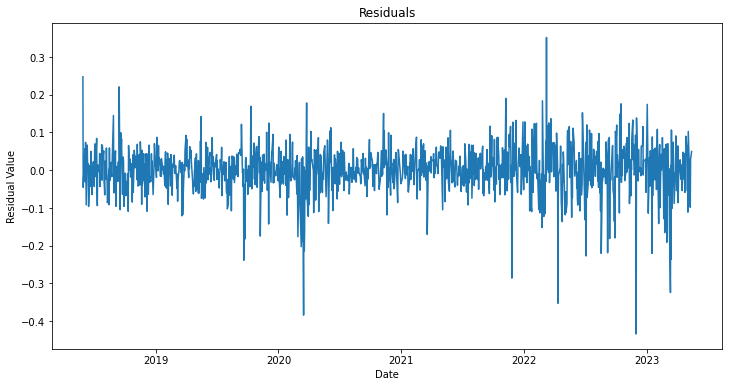

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2190.715, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2190.462, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2190.559, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2192.466, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2189.265, Time=0.50 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.047 seconds
                               SARIMAX Results                                
Dep. Variable:                  HIK.L   No. Observations:                 1252
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1097.233
Date:                Mon, 30 Oct 2023   AIC                          -2192.466
Time:                        17:08:17   BIC                          -2187.334
Sample:                             0   HQIC                         -2190.537
                               - 1252                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


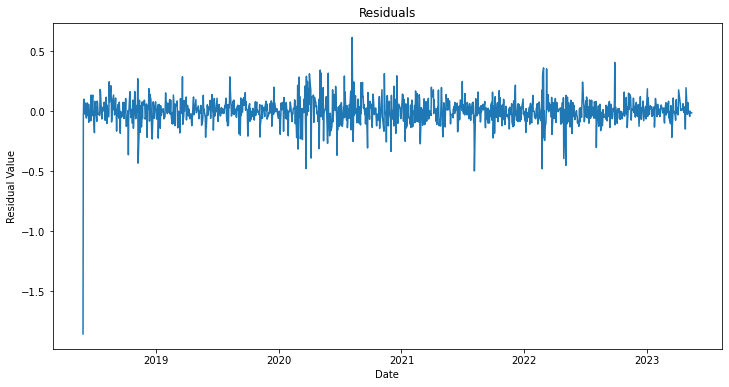

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2503.885, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2502.395, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2502.338, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2505.790, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2503.254, Time=0.67 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.660 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  ICP.L   No. Observations:                 1253
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1253.895
Date:                Mon, 30 Oct 2023   AIC                          -2505.790
Time:                        17:08:19   BIC                          -2500.658
Sample:                             0   HQIC                         -2503.861
                               - 1253                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0079      0.000     47.213      0.000       0.008       0.008
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):              1472.65
Prob(Q):                              0.47   Pr

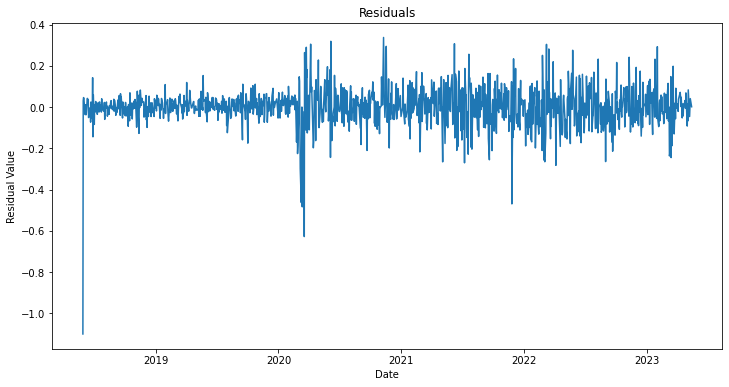

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3149.914, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3149.058, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3149.033, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3150.639, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3147.058, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.061 seconds
                               SARIMAX Results                                
Dep. Variable:                 DPLM.L   No. Observations:                 1253
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1576.319
Date:                Mon, 30 Oct 2023   AIC                          -3150.639
Time:                        17:08:21   BIC                          -3145.506
Sample:                             0   HQIC                         -3148.709
                               - 1253                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


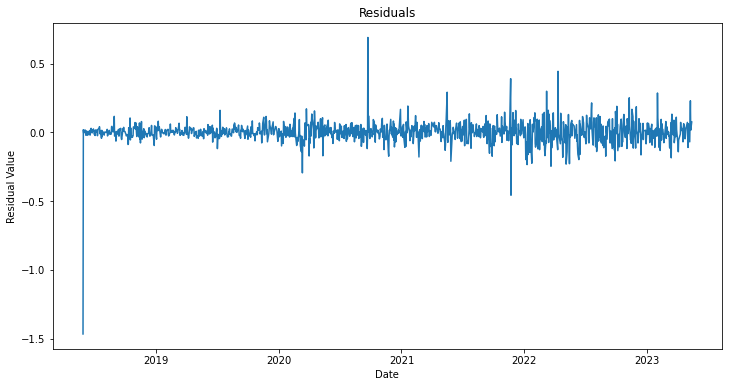

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2549.573, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2552.085, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2551.886, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2550.900, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2550.757, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2551.411, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2549.436, Time=1.19 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2553.326, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-2552.034, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2552.678, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2553.126, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-2549.981, Time=0.21 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.426 seconds
                               SARIMAX Results                              

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


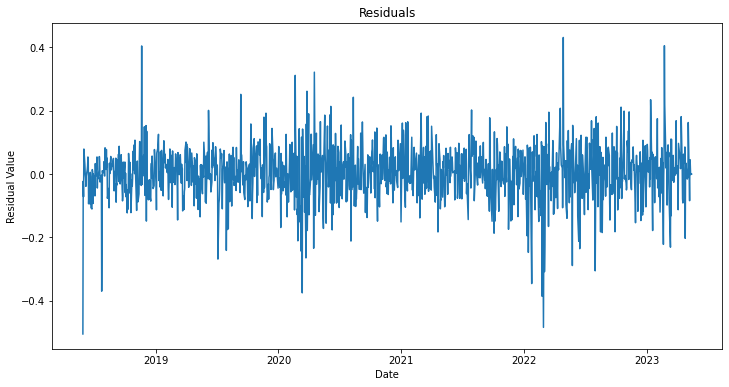

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2728.930, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2729.373, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2729.116, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2730.517, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2728.466, Time=0.91 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.575 seconds
                               SARIMAX Results                                
Dep. Variable:                 HWDN.L   No. Observations:                 1253
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1366.259
Date:                Mon, 30 Oct 2023   AIC                          -2730.517
Time:                        17:08:28   BIC                          -2725.385
Sample:                             0   HQIC                         -2728.588
                               - 1253                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


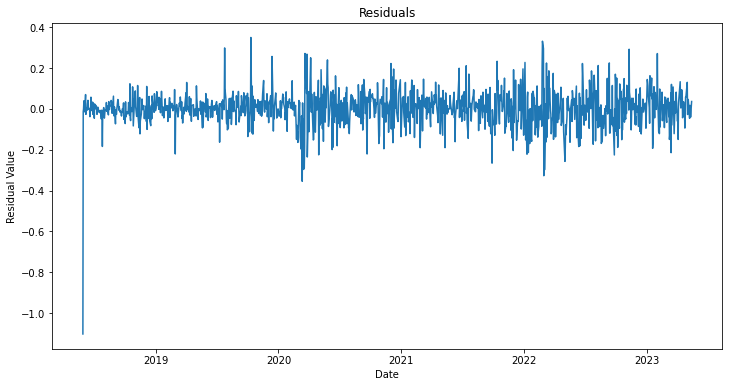

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2809.213, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2813.355, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2812.620, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2809.872, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2816.514, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-2815.740, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2815.271, Time=1.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2813.748, Time=0.65 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-2813.705, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-2817.489, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2814.190, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-2816.650, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-2816.221, Time=0.70 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2814.696, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  EZJ.L   No. Observations:                 1252
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1411.745
Date:                Mon, 30 Oct 2023   AIC                          -2817.489
Time:                        17:08:33   BIC                          -2802.094
Sample:                             0   HQIC                         -2811.702
                               - 1252                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0664      0.025      2.619      0.009       0.017       0.116
ar.L2          0.0651      0.019      3.397      0.001       0.028       0.103
sigma2         0.0061      0.000     59.220      0.0

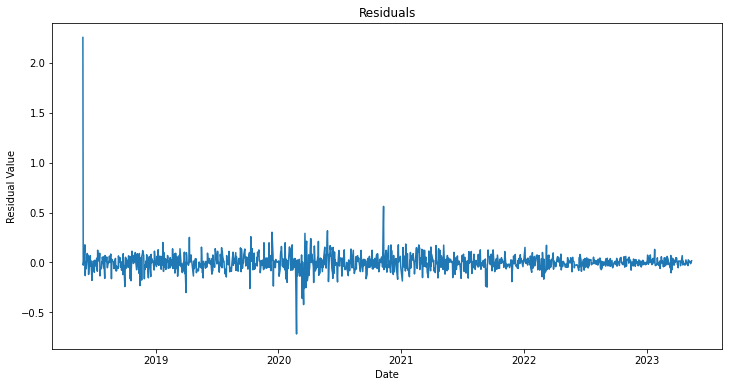

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-693.392, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-883.334, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-915.075, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-695.342, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-913.245, Time=1.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-913.229, Time=2.59 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-911.381, Time=0.84 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-916.884, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-915.058, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-915.042, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-885.221, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-913.194, Time=0.43 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 7.077 seconds
                               SARIMAX Results                                
Dep. Vari

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


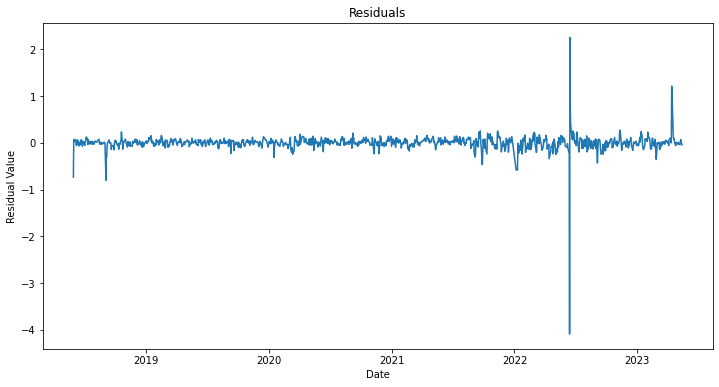

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-374.905, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-573.285, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-632.891, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-376.880, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-632.075, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-631.948, Time=0.67 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-630.521, Time=1.50 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-634.774, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-633.950, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-633.824, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-575.228, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-632.392, Time=0.45 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.211 seconds
                               SARIMAX Results                                
Dep. Vari

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


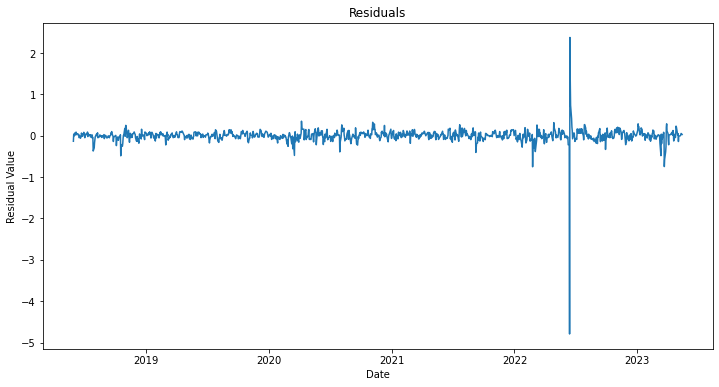

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2799.725, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2801.592, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2801.818, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2801.404, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2800.032, Time=0.58 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2800.424, Time=0.44 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2801.223, Time=0.97 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2803.531, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2801.701, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-2802.123, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2803.304, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-2802.947, Time=0.50 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.142 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  MKS.L   No. Observations:                 1253
Model:                 ARIMA(0, 1, 1)   Log Likelihood                1403.765
Date:                Mon, 30 Oct 2023   AIC                          -2803.531
Time:                        17:08:50   BIC                          -2793.266
Sample:                             0   HQIC                         -2799.672
                               - 1253                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0588      0.021      2.866      0.004       0.019       0.099
sigma2         0.0062      0.000     59.515      0.000       0.006       0.006
Ljung-Box (L1) (Q):                   0.00   Jarque-

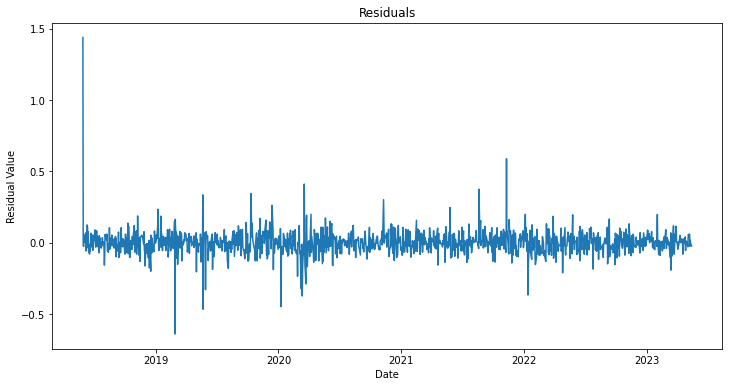

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1366.775, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1369.987, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1369.768, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1368.269, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1368.524, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1368.539, Time=0.62 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1366.584, Time=1.61 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1371.415, Time=0.39 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-1369.974, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1369.981, Time=0.37 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1371.195, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1368.032, Time=0.50 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 5.293 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxi

                               SARIMAX Results                                
Dep. Variable:                 TATE.L   No. Observations:                 1253
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 687.707
Date:                Mon, 30 Oct 2023   AIC                          -1371.415
Time:                        17:08:56   BIC                          -1361.150
Sample:                             0   HQIC                         -1367.556
                               - 1253                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0640      0.022     -2.931      0.003      -0.107      -0.021
sigma2         0.0195      0.000     45.052      0.000       0.019       0.020
Ljung-Box (L1) (Q):                   0.00   Jarque-

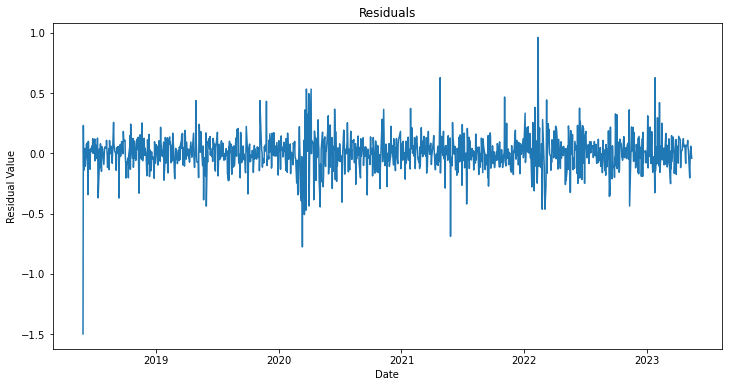

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2050.252, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2218.989, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2240.430, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2051.716, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2239.001, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2238.993, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2236.569, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2240.710, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2239.348, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-2239.343, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2219.859, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-2236.885, Time=0.16 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.536 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  GAW.L   No. Observations:                 1252
Model:                 ARIMA(0, 1, 1)   Log Likelihood                1122.355
Date:                Mon, 30 Oct 2023   AIC                          -2240.710
Time:                        17:08:59   BIC                          -2230.447
Sample:                             0   HQIC                         -2236.852
                               - 1252                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3971      0.003   -123.894      0.000      -0.403      -0.391
sigma2         0.0097   3.45e-05    282.079      0.000       0.010       0.010
Ljung-Box (L1) (Q):                   0.14   Jarque-

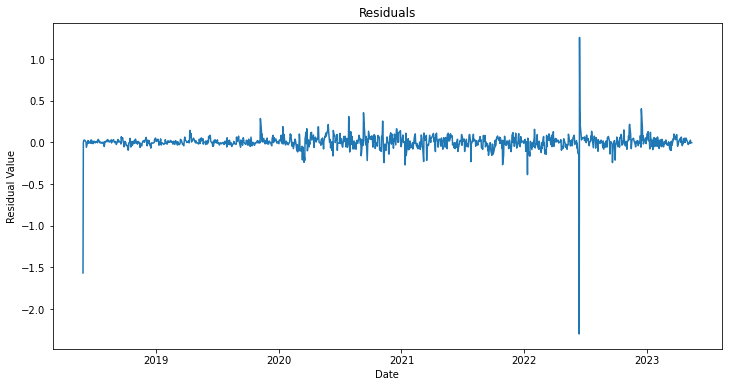

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1853.891, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1852.037, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1852.025, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1855.881, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1850.437, Time=0.62 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.280 seconds
                               SARIMAX Results                                
Dep. Variable:                 WIZZ.L   No. Observations:                 1253
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 928.941
Date:                Mon, 30 Oct 2023   AIC                          -1855.881
Time:                        17:09:01   BIC                          -1850.749
Sample:                             0   HQIC                         -1853.952
                               - 1253                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


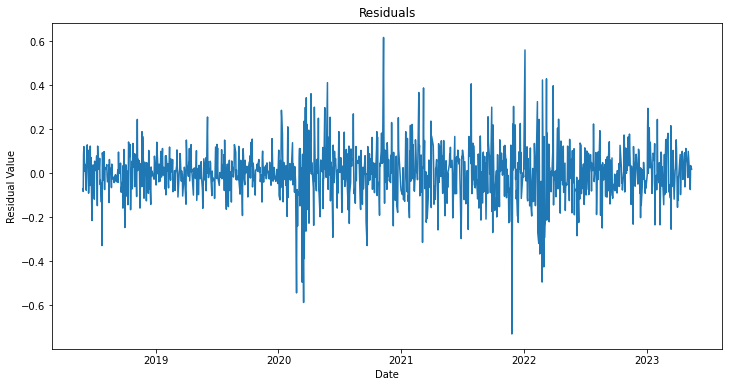

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2192.875, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2191.071, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2191.068, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2194.471, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2188.914, Time=0.54 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.374 seconds
                               SARIMAX Results                                
Dep. Variable:                  ITV.L   No. Observations:                 1253
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1098.235
Date:                Mon, 30 Oct 2023   AIC                          -2194.471
Time:                        17:09:03   BIC                          -2189.338
Sample:                             0   HQIC                         -2192.541
                               - 1253                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


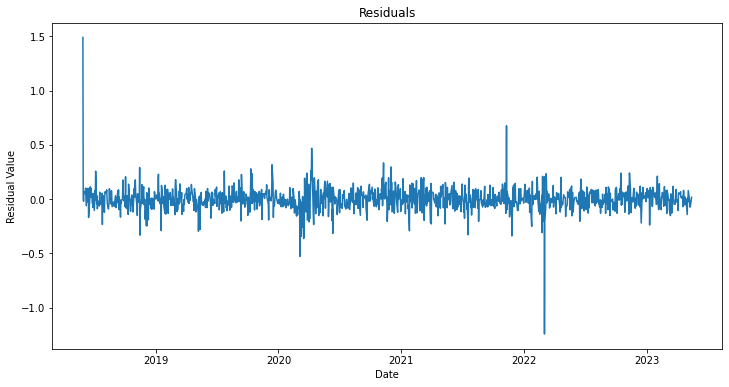

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1645.129, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1644.712, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1644.497, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1647.117, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1649.002, Time=0.99 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1648.469, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1648.409, Time=0.78 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1650.216, Time=0.42 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1648.354, Time=0.56 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1647.410, Time=2.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-1652.207, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1646.485, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1650.399, Time=0.30 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-1650.344, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  BWY.L   No. Observations:                 1252
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 829.103
Date:                Mon, 30 Oct 2023   AIC                          -1652.207
Time:                        17:09:11   BIC                          -1636.812
Sample:                             0   HQIC                         -1646.420
                               - 1252                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0346      0.022      1.574      0.115      -0.008       0.078
ma.L2          0.0775      0.021      3.718      0.000       0.037       0.118
sigma2         0.0156      0.000     45.675      0.0

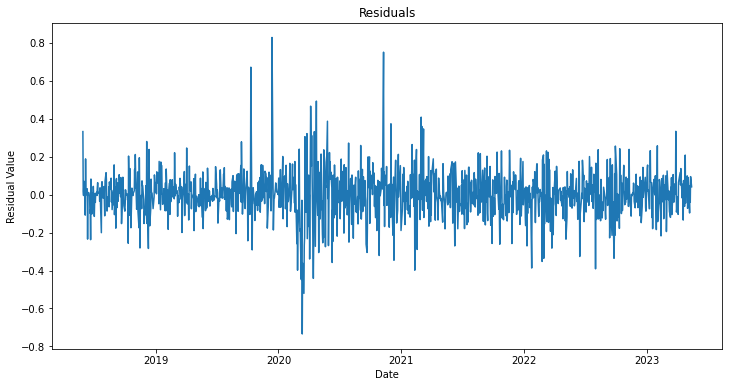

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2593.430, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2596.739, Time=0.61 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2596.545, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2595.359, Time=0.29 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2595.165, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2595.194, Time=0.83 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2593.133, Time=0.52 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2598.657, Time=0.31 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-2597.087, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2597.115, Time=0.39 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2598.462, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-2595.055, Time=0.22 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 4.255 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  IGG.L   No. Observations:                 1253
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1301.329
Date:                Mon, 30 Oct 2023   AIC                          -2598.657
Time:                        17:09:16   BIC                          -2588.392
Sample:                             0   HQIC                         -2594.799
                               - 1253                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0650      0.020     -3.252      0.001      -0.104      -0.026
sigma2         0.0073      0.000     61.239      0.000       0.007       0.008
Ljung-Box (L1) (Q):                   0.00   Jarque-

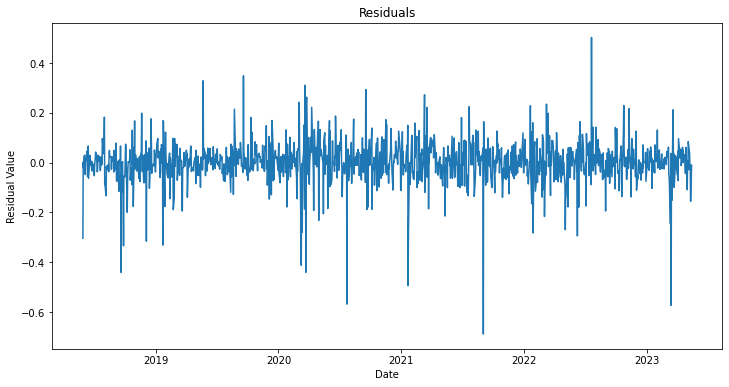

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=614.701, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=417.517, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=364.049, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=612.704, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=364.116, Time=0.65 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=364.522, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=364.259, Time=1.21 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=362.070, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=362.139, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=362.544, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=415.526, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=362.284, Time=0.69 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.441 seconds
                               SARIMAX Results                                
Dep. Variable:       

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


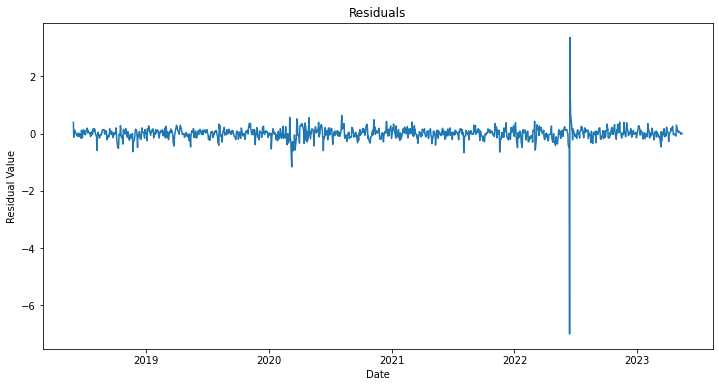

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4099.037, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4101.685, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4101.818, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4095.783, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4100.047, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4100.014, Time=0.66 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4098.006, Time=0.65 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4099.170, Time=0.18 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 2.476 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  TUI.L   No. Observations:                 1253
Model:                 ARIMA(0, 1, 1)   Log Likelihood                2051.585
Date:                Mon, 30 Oct 2023   AIC                          -4099.170
Time:                        17:09:25   BIC                          -4088.905
Sample:                             0   HQIC                         -4095.311
                               - 1253                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0662      0.019      3.413      0.001       0.028       0.104
sigma2         0.0022   2.78e-05     79.497      0.000       0.002       0.002
Ljung-Box (L1) (Q):                   0.02   Jarque-

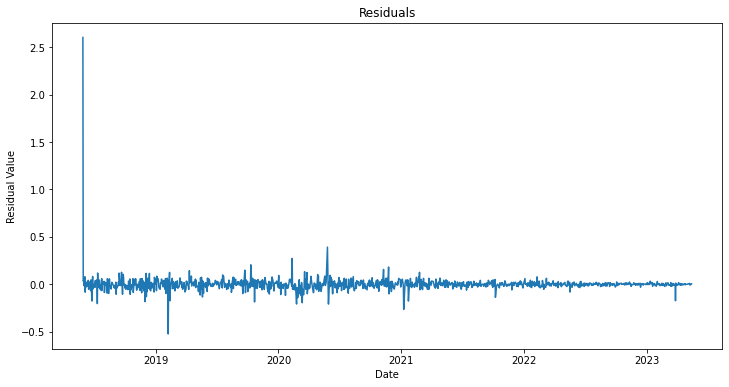

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2893.198, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2891.420, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2891.389, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2893.594, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2891.658, Time=0.82 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.609 seconds
                               SARIMAX Results                                
Dep. Variable:                  GRG.L   No. Observations:                 1253
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1447.797
Date:                Mon, 30 Oct 2023   AIC                          -2893.594
Time:                        17:09:27   BIC                          -2888.462
Sample:                             0   HQIC                         -2891.665
                               - 1253                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


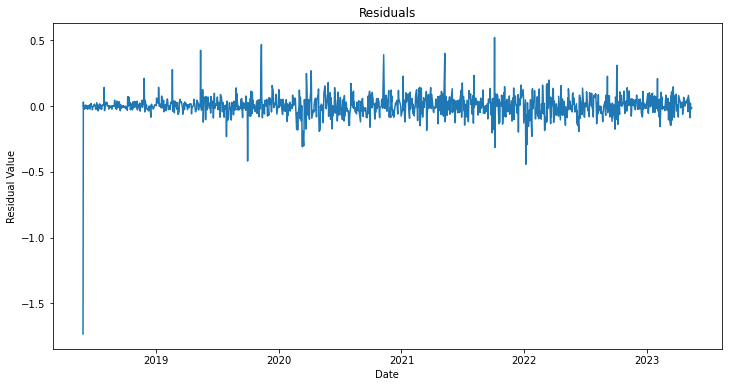

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-402.622, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-642.407, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-736.570, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-404.608, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-735.805, Time=0.51 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-735.676, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-732.862, Time=0.65 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-738.482, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-737.709, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-737.582, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-644.375, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-734.772, Time=0.20 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.548 seconds
                               SARIMAX Results                                
Dep. Vari

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


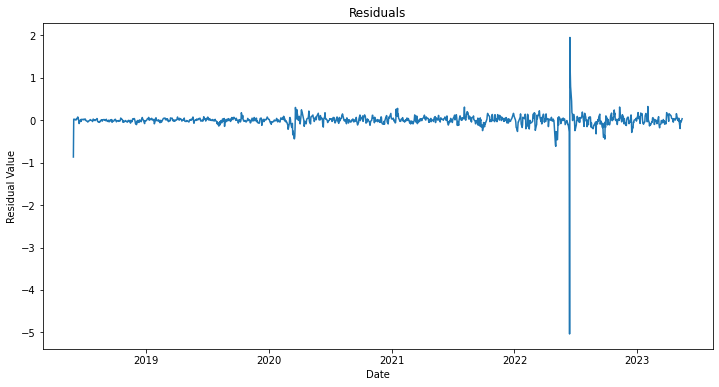

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1919.456, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1918.642, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1918.479, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1921.424, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1929.398, Time=0.42 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1929.872, Time=1.30 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1924.800, Time=0.32 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1928.037, Time=1.47 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1928.003, Time=1.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1929.789, Time=1.41 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-1925.552, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1926.503, Time=1.76 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1931.857, Time=0.47 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1931.405, Time=0.47 sec
 ARIMA(2,1,0)(0,0,0

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  VTY.L   No. Observations:                 1253
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 969.929
Date:                Mon, 30 Oct 2023   AIC                          -1931.857
Time:                        17:09:45   BIC                          -1911.327
Sample:                             0   HQIC                         -1924.140
                               - 1253                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7681      0.088      8.773      0.000       0.597       0.940
ar.L2          0.0506      0.026      1.964      0.050       0.000       0.101
ma.L1         -0.7487      0.084     -8.923      0.0

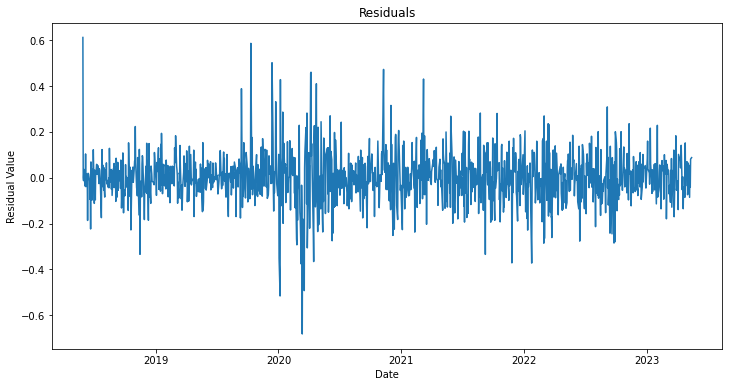

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3262.846, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3261.230, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3261.207, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3264.054, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3259.005, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.059 seconds
                               SARIMAX Results                                
Dep. Variable:                  CCC.L   No. Observations:                 1253
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1633.027
Date:                Mon, 30 Oct 2023   AIC                          -3264.054
Time:                        17:09:47   BIC                          -3258.921
Sample:                             0   HQIC                         -3262.124
                               - 1253                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


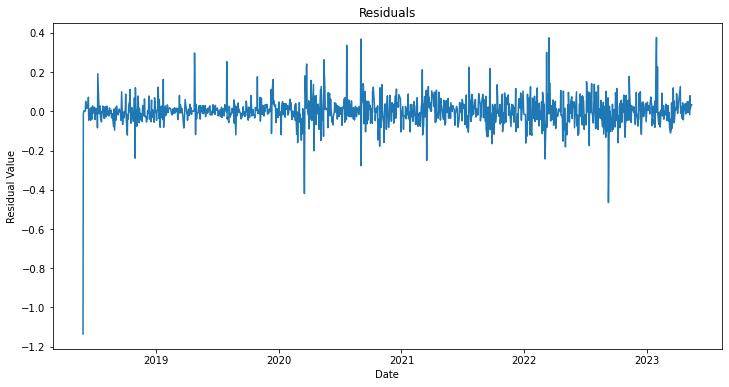

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [23]:
look_forward = 3
dict_df = get_ARIMA_PRED(df_standardised, look_forward)

In [24]:
dict_df_T = dict_df.T

In [25]:
###############################
#PRODUCE NAIVE PREDICTION
naive_predictions = []
for column in df_standardised.columns:
    naive_predictions.append(df_standardised[column].iloc[-4])
dict_df_T["naive_prediction"] = naive_predictions


In [26]:
dict_df_T

,optimal_p,optimal_q,optimal_d,ARIMA_prediction,naive_prediction
BEZ.L,0.0,0.0,1.0,1.524319,1.524319
PSN.L,0.0,0.0,1.0,-1.025107,-1.025107
HSX.L,0.0,0.0,1.0,0.393769,0.393769
RS1.L,0.0,0.0,1.0,0.346503,0.346503
UTG.L,1.0,2.0,0.0,-0.080037,-0.088370
JMAT.L,0.0,0.0,1.0,-1.155003,-1.155003
BLND.L,0.0,0.0,1.0,-1.192617,-1.192617
FRAS.L,0.0,0.0,1.0,1.458217,1.458217
OCDO.L,0.0,0.0,1.0,-1.566430,-1.566430
CCL.L,0.0,0.0,1.0,-1.032575,-1.032575


In [27]:
#verifying that the naive prediction is identical with the actual price.iloc[-4]

df_standardised.iloc[-4] == dict_df_T["naive_prediction"]

Ticker_Symbol
BEZ.L     True
PSN.L     True
HSX.L     True
RS1.L     True
UTG.L     True
JMAT.L    True
BLND.L    True
FRAS.L    True
OCDO.L    True
CCL.L     True
IMI.L     True
INVP.L    True
HIK.L     True
ICP.L     True
DPLM.L    True
SXS.L     True
HWDN.L    True
EZJ.L     True
DPH.L     True
INCH.L    True
MKS.L     True
TATE.L    True
GAW.L     True
WIZZ.L    True
ITV.L     True
BWY.L     True
IGG.L     True
ROR.L     True
TUI.L     True
GRG.L     True
BBOX.L    True
VTY.L     True
CCC.L     True
dtype: bool

In [28]:
dict_df_T["ARIMA_prediction"] == dict_df_T["naive_prediction"]

BEZ.L      True
PSN.L      True
HSX.L      True
RS1.L      True
UTG.L     False
JMAT.L     True
BLND.L     True
FRAS.L     True
OCDO.L     True
CCL.L      True
IMI.L      True
INVP.L     True
HIK.L      True
ICP.L      True
DPLM.L     True
SXS.L      True
HWDN.L     True
EZJ.L     False
DPH.L     False
INCH.L    False
MKS.L     False
TATE.L    False
GAW.L     False
WIZZ.L     True
ITV.L      True
BWY.L     False
IGG.L      True
ROR.L     False
TUI.L     False
GRG.L      True
BBOX.L    False
VTY.L     False
CCC.L      True
dtype: bool

In [29]:
(dict_df_T["ARIMA_prediction"] == dict_df_T["naive_prediction"]).value_counts()

True     21
False    12
Name: count, dtype: int64

In [30]:
param_df = dict_df_T[dict_df_T["ARIMA_prediction"] != dict_df_T["naive_prediction"]]
param_df

,optimal_p,optimal_q,optimal_d,ARIMA_prediction,naive_prediction
UTG.L,1.0,2.0,0.0,-0.080037,-0.088370
EZJ.L,2.0,0.0,1.0,-0.964281,-0.965762
DPH.L,0.0,1.0,1.0,0.737896,0.718822
INCH.L,0.0,1.0,1.0,1.031901,1.047212
MKS.L,0.0,1.0,1.0,-0.144673,-0.143327
TATE.L,1.0,0.0,1.0,2.026218,2.023569
GAW.L,0.0,1.0,1.0,1.188432,1.186883
BWY.L,0.0,2.0,1.0,-0.142568,-0.154595
ROR.L,0.0,1.0,1.0,1.061741,1.063231
TUI.L,0.0,1.0,1.0,-1.211639,-1.211914


In [31]:
#create a new dataframe for comparison of analysis

comparision_df = pd.DataFrame(index = param_df.index)

In [32]:
#file["Actual Price"].index = dict_df_T.index.to_list()
comparision_df["ARIMA_prediction"]=param_df["ARIMA_prediction"]
comparision_df["naive_prediction"]=param_df["naive_prediction"]

In [33]:
comparision_df["Actual Price, y"] = actual_price_df.loc[comparision_df.index].values 

In [34]:
comparision_df["SE_ARIMA"] =\
(
    np.square(comparision_df["ARIMA_prediction"].values - comparision_df["Actual Price, y"].values) 
)

comparision_df["SE_naive"] =\
(
    np.square(comparision_df["naive_prediction"].values - actual_price_df["actual_price"].loc[param_df.index].values)
)
comparision_df

,ARIMA_prediction,naive_prediction,"Actual Price, y",SE_ARIMA,SE_naive
UTG.L,-0.080037,-0.088370,-0.389640,0.095854,0.090763
EZJ.L,-0.964281,-0.965762,-0.989962,0.000659,0.000586
DPH.L,0.737896,0.718822,0.006638,0.534737,0.507206
INCH.L,1.031901,1.047212,0.974527,0.003292,0.005283
MKS.L,-0.144673,-0.143327,0.099181,0.059465,0.058810
TATE.L,2.026218,2.023569,1.781179,0.060044,0.058753
GAW.L,1.188432,1.186883,1.040984,0.021741,0.021286
BWY.L,-0.142568,-0.154595,-0.500866,0.128378,0.119903
ROR.L,1.061741,1.063231,0.993592,0.004644,0.004850
TUI.L,-1.211639,-1.211914,-1.207093,0.000021,0.000023


In [35]:
dict_df_T["Actual Price, y"] = actual_price_df.loc[dict_df_T.index].values

In [36]:
dict_df_T["SE_ARIMA"] =\
(
    np.square(dict_df_T["ARIMA_prediction"].values - dict_df_T["Actual Price, y"].values) 
)

dict_df_T["SE_naive"] =\
(
    np.square(dict_df_T["naive_prediction"].values - dict_df_T["Actual Price, y"].values)
)
dict_df_T

,optimal_p,optimal_q,optimal_d,ARIMA_prediction,naive_prediction,"Actual Price, y",SE_ARIMA,SE_naive
BEZ.L,0.0,0.0,1.0,1.524319,1.524319,1.462262,3.851131e-03,3.851131e-03
PSN.L,0.0,0.0,1.0,-1.025107,-1.025107,-1.282456,6.622833e-02,6.622833e-02
HSX.L,0.0,0.0,1.0,0.393769,0.393769,0.393230,2.898589e-07,2.898589e-07
RS1.L,0.0,0.0,1.0,0.346503,0.346503,0.083260,6.929705e-02,6.929705e-02
UTG.L,1.0,2.0,0.0,-0.080037,-0.088370,-0.389640,9.585401e-02,9.076321e-02
JMAT.L,0.0,0.0,1.0,-1.155003,-1.155003,-1.458119,9.187978e-02,9.187978e-02
BLND.L,0.0,0.0,1.0,-1.192617,-1.192617,-1.653533,2.124439e-01,2.124439e-01
FRAS.L,0.0,0.0,1.0,1.458217,1.458217,0.904425,3.066859e-01,3.066859e-01
OCDO.L,0.0,0.0,1.0,-1.566430,-1.566430,-1.599543,1.096473e-03,1.096473e-03
CCL.L,0.0,0.0,1.0,-1.032575,-1.032575,-0.970239,3.885742e-03,3.885742e-03


In [37]:
#market share extraction. market share on rank date strictly

tickers = symbols_short

def extract_sp(stocks, start, end):
    def data(ticker):
        return(yf.Ticker(ticker).get_shares_full(start= start, end=end))
    FAANG_Stock = map(data, stocks)
    return(pd.concat(FAANG_Stock,
                     keys = stocks,
                     names = ["Company", "Date"]
                    )
          )


result_ = extract_sp(tickers,start="2023-05-24", end="2023-05-30")
result_df = pd.DataFrame(result_, columns = ['Market Share'])
market_share_df_strict =\
(
    result_df
    .reset_index()
    .sort_values(by='Date', ascending = False)
    .drop_duplicates(subset='Company', keep='last')

)

market_share_df_strict

,Company,Date,Market Share
47,WIZZ.L,2023-05-27 00:00:00+01:00,103293000
37,DPH.L,2023-05-27 00:00:00+01:00,113884000
59,ROR.L,2023-05-27 00:00:00+01:00,862974976
44,TATE.L,2023-05-27 00:00:00+01:00,401636992
25,HIK.L,2023-05-26 00:00:00+01:00,222858000
63,VTY.L,2023-05-26 00:00:00+01:00,345950016
6,UTG.L,2023-05-26 00:00:00+01:00,404183008
38,INCH.L,2023-05-26 00:00:00+01:00,420728992
23,INVP.L,2023-05-26 00:00:00+01:00,661745984
35,EZJ.L,2023-05-26 00:00:00+01:00,764102016


In [38]:
### market share NEAR rank date

def extract_sp(stocks, start, end):
    def data(ticker):
        return(yf.Ticker(ticker).get_shares_full(start= start, end=end))
    FAANG_Stock = map(data, stocks)
    return(pd.concat(FAANG_Stock,
                     keys = stocks,
                     names = ["Company", "Date"]
                    )
          )

#tickers = ['AAPL','MSFT']

tickers = symbols_short

result_ = extract_sp(tickers,start="2015-05-23", end="2023-05-30")
result_df = pd.DataFrame(result_, columns = ['Market Share'])
market_share_df =\
(
    result_df
    .reset_index()
    .sort_values(by='Date', ascending = False)
    .drop_duplicates(subset='Company', keep='first')

)

market_share_df

,Company,Date,Market Share
11701,CCC.L,2023-05-30 00:00:00+01:00,114141000
6151,HWDN.L,2023-05-30 00:00:00+01:00,555116992
9363,BWY.L,2023-05-30 00:00:00+01:00,125242000
1506,UTG.L,2023-05-30 00:00:00+01:00,404183008
2235,BLND.L,2023-05-30 00:00:00+01:00,956312000
3512,CCL.L,2023-05-28 00:00:00+01:00,1214569984
2948,OCDO.L,2023-05-28 00:00:00+01:00,836313984
5688,SXS.L,2023-05-27 00:00:00+01:00,104633000
4577,HIK.L,2023-05-27 00:00:00+01:00,220700000
9677,IGG.L,2023-05-27 00:00:00+01:00,410903008


In [39]:
#checking for stock that doesnt have market share extracted


dict_df_T.index[~dict_df_T.index.isin(market_share_df["Company"].to_list())]

Index([], dtype='object')

In [40]:
market_share_df_ = market_share_df.set_index("Company")
ordered_market_share_df = market_share_df_.loc[dict_df_T.index]
ordered_market_share_df

,Date,Market Share
BEZ.L,2023-05-14 00:00:00+01:00,672204992
PSN.L,2023-05-26 00:00:00+01:00,319398016
HSX.L,2023-05-26 00:00:00+01:00,346552000
RS1.L,2023-05-26 00:00:00+01:00,472800000
UTG.L,2023-05-30 00:00:00+01:00,404183008
JMAT.L,2023-05-27 00:00:00+01:00,190676992
BLND.L,2023-05-30 00:00:00+01:00,956312000
FRAS.L,2023-05-27 00:00:00+01:00,490780000
OCDO.L,2023-05-28 00:00:00+01:00,836313984
CCL.L,2023-05-28 00:00:00+01:00,1214569984


In [41]:
#un-normalise the actual_price
ticker_mean_df = pd.Series(ticker_mean_dict.values(), index = ticker_mean_dict.keys())
ticker_std_df = pd.Series(ticker_std_dict.values(), index = ticker_std_dict.keys())

dict_df_T["un-normalised_actual_mrkt_share"] = pd.Series((actual_price_df.values.flatten() * ticker_std_df.values) + ticker_mean_df.values, index = actual_price_df.index)
dict_df_T["un-normalised_ARIMA_pred_mrkt_share"] = pd.Series((dict_df_T["ARIMA_prediction"].values * ticker_std_df.values) + ticker_mean_df.values, index = actual_price_df.index)
dict_df_T["un-normalised_naive_pred_mrkt_share"] = pd.Series((dict_df_T["naive_prediction"].values * ticker_std_df.values) + ticker_mean_df.values, index = actual_price_df.index)
result = dict_df_T[["un-normalised_actual_mrkt_share", "un-normalised_ARIMA_pred_mrkt_share", "un-normalised_naive_pred_mrkt_share"]].mul(ordered_market_share_df["Market Share"], axis=0)
result.head(3)


,un-normalised_actual_mrkt_share,un-normalised_ARIMA_pred_mrkt_share,un-normalised_naive_pred_mrkt_share
BEZ.L,4.093728e+11,4.134837e+11,4.134837e+11
PSN.L,3.842075e+11,4.184470e+11,4.184470e+11
HSX.L,4.015522e+11,4.016017e+11,4.016017e+11


In [42]:
symbols['Ticker'] = symbols['Ticker'].str.split(' ').str[0]
symbols['Ticker'] = symbols['Ticker'] + ".L"
symbols.head(3)

,Ticker,Name,Weight,Shares,Price,Market Cap,SEDOL,ISIN,Index,Ticker_Symbol
0,BEZ.L,Beazley PLC,0.204796,659.992581,619.0,4161135104,BYQ0JC6,GB00BYQ0JC66,FTSE100,BEZ.L
1,PSN.L,Persimmon PLC,0.204632,317.424226,1286.0,4107688192,0682538,GB0006825383,FTSE100,PSN.L
2,HSX.L,Hiscox Ltd,0.197161,335.012096,1174.0,4068541952,BVZHXQ9,BMG4593F1389,FTSE100,HSX.L


In [43]:
#result is the prediction results
result2 = result.reset_index().rename(columns = {"index": "Ticker"})
merged = result2.merge(symbols, how='left', on='Ticker') #target universe is list before rank date
merged.head(3)

,Ticker,un-normalised_actual_mrkt_share,un-normalised_ARIMA_pred_mrkt_share,un-normalised_naive_pred_mrkt_share,Name,Weight,Shares,Price,Market Cap,SEDOL,ISIN,Index,Ticker_Symbol
0,BEZ.L,4.093728e+11,4.134837e+11,4.134837e+11,Beazley PLC,0.204796,659.992581,619.0,4161135104,BYQ0JC6,GB00BYQ0JC66,FTSE100,BEZ.L
1,PSN.L,3.842075e+11,4.184470e+11,4.184470e+11,Persimmon PLC,0.204632,317.424226,1286.0,4107688192,0682538,GB0006825383,FTSE100,PSN.L
2,HSX.L,4.015522e+11,4.016017e+11,4.016017e+11,Hiscox Ltd,0.197161,335.012096,1174.0,4068541952,BVZHXQ9,BMG4593F1389,FTSE100,HSX.L


In [44]:
## 90percentile decision module + confusion matrix 

In [45]:
#this is the decision module
def get_top10(merged_df, column):
    merged_df2 = merged_df.sort_values(by=column, ascending = False).reset_index(drop=True)
    ftse_250 = merged_df2[merged_df2["Index"] =='FTSE250']
    ftse_100 = merged_df2[merged_df2["Index"] =='FTSE100']

    # list of stocks that is going into FTSE100
    stocks_into_FTSE100 = ftse_250[ftse_250.index<ftse_100.index[0]]['Ticker'].to_list()

    # number of stocks that is going into FTSE100
    number_of_stocks = len(stocks_into_FTSE100)

    # list of stocks that is going out from FTSE100
    stocks_out_from_FTSE100 = ftse_100['Ticker'].tail(number_of_stocks).to_list()
    
    return stocks_into_FTSE100, stocks_out_from_FTSE100

stocks_into_FTSE100_naive, stocks_out_from_FTSE100_naive = get_top10(merged, "un-normalised_naive_pred_mrkt_share")
stocks_into_FTSE100_ARIMA, stocks_out_from_FTSE100_ARIMA = get_top10(merged, "un-normalised_ARIMA_pred_mrkt_share")


date = "2023-06-19"

def confusion_matrix(stocks_into_FTSE100, stocks_out_from_FTSE100, date):
    post_rebalancing = pd.read_csv("ftse100_rebalancing_summary.csv")
    post_rebalancing_ = post_rebalancing[post_rebalancing["Post Date"] ==  date]
    
    post_rebalancing_['Ticker'] = post_rebalancing_['Ticker'].str.split(' ').str[0]
    post_rebalancing_['Ticker'] = post_rebalancing_['Ticker'] + ".L"

    true_positive_100 =\
    (
        post_rebalancing_[post_rebalancing_["FTSE100"] == -1.0]["Ticker"]
    )
    true_negative_100 =\
    (
        post_rebalancing_[post_rebalancing_["FTSE100"] == 1.0]["Ticker"]
    )
#     true_positive_250 =\
#     (
#         post_rebalancing_[post_rebalancing_["FTSE250"] == 1.0]["Ticker"]
#     )
#     true_negative_250 =\
#     (
#         post_rebalancing_[post_rebalancing_["FTSE250"] == -1.0]["Ticker"]
#     )
    
    true_positive_count = 0
    true_negative_count = 0
    
    for outgoing in stocks_out_from_FTSE100:
        if true_positive_100.isin([outgoing]).any():
            true_positive_count+=1
    
    for incoming in stocks_into_FTSE100:
        if true_negative_100.isin([incoming]).any():
            true_negative_count+=1
            
    #reconfirm the top10 predicted
    going_up_length = len(stocks_into_FTSE100)

    retained_in_top10 = list(symbols["Ticker"].iloc[:10 - going_up_length].values)
    retained_in_top10.extend(stocks_into_FTSE100)

    #reconfirm the bottom 25 predicted
    coming_down_length = len(stocks_out_from_FTSE100)

    retained_in_bottom25 = list(symbols["Ticker"].iloc[(10 + coming_down_length):].values)
    retained_in_bottom25.extend(stocks_into_FTSE100)
    
    
#     true_positive = true_positive_count / len(retained_in_top10 + retained_in_bottom25)
#     false_positive = (len(retained_in_top10)-true_positive_count) / len(retained_in_top10 + retained_in_bottom25)
#     true_negative = true_negative_count / len(retained_in_top10 + retained_in_bottom25)
#     false_negative = (len(retained_in_bottom25)-true_negative_count) / len(retained_in_top10 + retained_in_bottom25)
    
    true_positive = true_positive_count / (len(stocks_out_from_FTSE100) + len(stocks_into_FTSE100))
    false_positive = (len(stocks_out_from_FTSE100) - true_positive_count) / (len(stocks_out_from_FTSE100) + len(stocks_into_FTSE100))
    true_negative = true_negative_count / (len(stocks_out_from_FTSE100) + len(stocks_into_FTSE100))
    false_negative = (len(stocks_into_FTSE100) - true_negative_count) / (len(stocks_out_from_FTSE100) + len(stocks_into_FTSE100))
    
    #can return retained_in_top10 and retained_in_bottom25 to know the ordered prediction of top10&bottom25 if we want
    return true_positive, false_positive, true_negative, false_negative
    

In [46]:
true_positive_naive, false_positive_naive, true_negative_naive, false_negative_naive = confusion_matrix(stocks_into_FTSE100_naive, stocks_out_from_FTSE100_naive, date)
true_positive_ARIMA, false_positive_ARIMA, true_negative_ARIMA, false_negative_ARIMA = confusion_matrix(stocks_into_FTSE100_ARIMA, stocks_out_from_FTSE100_ARIMA, date)

/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_5899/2300570370.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_rebalancing_['Ticker'] = post_rebalancing_['Ticker'].str.split(' ').str[0]
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_5899/2300570370.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_rebalancing_['Ticker'] = post_rebalancing_['Ticker'] + ".L"
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_5899/2300570370.py:28: SettingWithCopyWarning: 
A va

In [47]:
#logic check, must sum to 1
sum(confusion_matrix(stocks_into_FTSE100_naive, stocks_out_from_FTSE100_naive,date))

/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_5899/2300570370.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_rebalancing_['Ticker'] = post_rebalancing_['Ticker'].str.split(' ').str[0]
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_5899/2300570370.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_rebalancing_['Ticker'] = post_rebalancing_['Ticker'] + ".L"


1.0

In [48]:
#logic check, must sum to 1
sum(confusion_matrix(stocks_into_FTSE100_ARIMA, stocks_out_from_FTSE100_ARIMA,date))

/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_5899/2300570370.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_rebalancing_['Ticker'] = post_rebalancing_['Ticker'].str.split(' ').str[0]
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_5899/2300570370.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_rebalancing_['Ticker'] = post_rebalancing_['Ticker'] + ".L"


1.0

In [49]:
print("Percentage of true positive in naive model is {:.3f}%".format(true_positive_naive*100))
print("Percentage of true negative in naive model is {:.3f}%".format(true_negative_naive*100))
print("Percentage of false positive in naive model is {:.3f}%".format(false_positive_naive*100))
print("Percentage of false negative in naive model is {:.3f}%".format(false_negative_naive*100))

Percentage of true positive in naive model is 16.667%
Percentage of true negative in naive model is 16.667%
Percentage of false positive in naive model is 33.333%
Percentage of false negative in naive model is 33.333%


In [50]:
print("Percentage of true positive in ARIMA model is {:.3f}%".format(true_positive_ARIMA*100))
print("Percentage of true negative in ARIMA model is {:.3f}%".format(true_negative_ARIMA*100))
print("Percentage of false positive in ARIMA model is {:.3f}%".format(false_positive_ARIMA*100))
print("Percentage of false negative in ARIMA model is {:.3f}%".format(false_negative_ARIMA*100))

Percentage of true positive in ARIMA model is 16.667%
Percentage of true negative in ARIMA model is 16.667%
Percentage of false positive in ARIMA model is 33.333%
Percentage of false negative in ARIMA model is 33.333%


In [51]:
#same false positive between ARIMA and NAIVE.

In [52]:
#param_df shows us the parameters that gave different ARIMA and Naive predictions

### remaining portion was used to generate outstanding market shares

In [53]:
# sheet_name = ['20220526','20220825','20221124','20230223','20230525']


In [54]:
# ### market share NEAR rank date

# symbols = pd.read_excel("target_stock_universe.xlsx", sheet_name = sheet_name[4]) # change here to get the other sheet
# symbols['Ticker_Symbol'] = symbols['Ticker'].str.split().str[0]+".L"
# symbols = symbols[symbols['Ticker_Symbol']!='HSV.L']
# symbols = symbols[symbols['Ticker_Symbol']!='HBR.L']
# symbols = symbols[symbols['Ticker_Symbol']!='TW/.L']
# symbols = symbols[symbols['Ticker_Symbol']!='MDC.L']
# symbols = symbols[symbols['Ticker_Symbol']!='HL/.L']


# symbols_short = symbols['Ticker_Symbol']

# def extract_sp(stocks, start, end):
#     def data(ticker):
#         return(yf.Ticker(ticker).get_shares_full(start= start, end=end))
#     FAANG_Stock = map(data, stocks)
#     return(pd.concat(FAANG_Stock,
#                      keys = stocks,
#                      names = ["Company", "Date"]
#                     )
#           )

# #tickers = ['AAPL','MSFT']

# tickers = symbols_short

# result_ = extract_sp(tickers,start="2015-05-23", end="2023-05-30")
# result_df = pd.DataFrame(result_, columns = ['Market Share'])
# market_share_df_20230530 =\
# (
#     result_df
#     .reset_index()
#     .sort_values(by='Date', ascending = False)
#     .drop_duplicates(subset='Company', keep='first')

# )

# #market_share_df_20230530

In [55]:
# symbols = pd.read_excel("target_stock_universe.xlsx", sheet_name = sheet_name[3]) # change here to get the other sheet
# symbols['Ticker_Symbol'] = symbols['Ticker'].str.split().str[0]+".L"
# symbols = symbols[symbols['Ticker_Symbol']!='HSV.L']
# symbols = symbols[symbols['Ticker_Symbol']!='HBR.L']
# symbols = symbols[symbols['Ticker_Symbol']!='TW/.L']
# symbols = symbols[symbols['Ticker_Symbol']!='MDC.L']
# symbols = symbols[symbols['Ticker_Symbol']!='HL/.L']


# symbols_short = symbols['Ticker_Symbol']


# def extract_sp(stocks, start, end):
#     def data(ticker):
#         return(yf.Ticker(ticker).get_shares_full(start= start, end=end))
#     FAANG_Stock = map(data, stocks)
#     return(pd.concat(FAANG_Stock,
#                      keys = stocks,
#                      names = ["Company", "Date"]
#                     )
#           )

# #tickers = ['AAPL','MSFT']

# tickers = symbols_short

# result_ = extract_sp(tickers,start="2015-02-26", end="2023-02-28")
# result_df = pd.DataFrame(result_, columns = ['Market Share'])
# market_share_df_20230228 =\
# (
#     result_df
#     .reset_index()
#     .sort_values(by='Date', ascending = False)
#     .drop_duplicates(subset='Company', keep='first')

# )

# #market_share_df_20230228

In [56]:
# symbols = pd.read_excel("target_stock_universe.xlsx", sheet_name = sheet_name[2]) # change here to get the other sheet
# symbols['Ticker_Symbol'] = symbols['Ticker'].str.split().str[0]+".L"
# symbols = symbols[symbols['Ticker_Symbol']!='HSV.L']
# symbols = symbols[symbols['Ticker_Symbol']!='HBR.L']
# symbols = symbols[symbols['Ticker_Symbol']!='TW/.L']
# symbols = symbols[symbols['Ticker_Symbol']!='MDC.L']
# symbols = symbols[symbols['Ticker_Symbol']!='HL/.L']


# symbols_short = symbols['Ticker_Symbol']

# def extract_sp(stocks, start, end):
#     def data(ticker):
#         return(yf.Ticker(ticker).get_shares_full(start= start, end=end))
#     FAANG_Stock = map(data, stocks)
#     return(pd.concat(FAANG_Stock,
#                      keys = stocks,
#                      names = ["Company", "Date"]
#                     )
#           )

# #tickers = ['AAPL','MSFT']

# tickers = symbols_short

# result_ = extract_sp(tickers,start="2015-02-25", end="2022-11-29")
# result_df = pd.DataFrame(result_, columns = ['Market Share'])
# market_share_df_20221129 =\
# (
#     result_df
#     .reset_index()
#     .sort_values(by='Date', ascending = False)
#     .drop_duplicates(subset='Company', keep='first')

# )

# #market_share_df_20221129

In [57]:
# symbols = pd.read_excel("target_stock_universe.xlsx", sheet_name = sheet_name[1]) # change here to get the other sheet
# symbols['Ticker_Symbol'] = symbols['Ticker'].str.split().str[0]+".L"
# symbols = symbols[symbols['Ticker_Symbol']!='HSV.L']
# symbols = symbols[symbols['Ticker_Symbol']!='HBR.L']
# symbols = symbols[symbols['Ticker_Symbol']!='TW/.L']
# symbols = symbols[symbols['Ticker_Symbol']!='MDC.L']
# symbols = symbols[symbols['Ticker_Symbol']!='HL/.L']


# symbols_short = symbols['Ticker_Symbol']

# def extract_sp(stocks, start, end):
#     def data(ticker):
#         return(yf.Ticker(ticker).get_shares_full(start= start, end=end))
#     FAANG_Stock = map(data, stocks)
#     return(pd.concat(FAANG_Stock,
#                      keys = stocks,
#                      names = ["Company", "Date"]
#                     )
#           )

# #tickers = ['AAPL','MSFT']

# tickers = symbols_short

# result_ = extract_sp(tickers,start="2015-02-26", end="2022-08-30")
# result_df = pd.DataFrame(result_, columns = ['Market Share'])
# market_share_df_20220830 =\
# (
#     result_df
#     .reset_index()
#     .sort_values(by='Date', ascending = False)
#     .drop_duplicates(subset='Company', keep='first')

# )

# #market_share_df_20220830

In [58]:
# symbols = pd.read_excel("target_stock_universe.xlsx", sheet_name = sheet_name[0]) # change here to get the other sheet
# symbols['Ticker_Symbol'] = symbols['Ticker'].str.split().str[0]+".L"
# symbols = symbols[symbols['Ticker_Symbol']!='HSV.L']
# symbols = symbols[symbols['Ticker_Symbol']!='HBR.L']
# symbols = symbols[symbols['Ticker_Symbol']!='TW/.L']
# symbols = symbols[symbols['Ticker_Symbol']!='MDC.L']
# symbols = symbols[symbols['Ticker_Symbol']!='HL/.L']


# symbols_short = symbols['Ticker_Symbol']

# def extract_sp(stocks, start, end):
#     def data(ticker):
#         return(yf.Ticker(ticker).get_shares_full(start= start, end=end))
#     FAANG_Stock = map(data, stocks)
#     return(pd.concat(FAANG_Stock,
#                      keys = stocks,
#                      names = ["Company", "Date"]
#                     )
#           )

# #tickers = ['AAPL','MSFT']

# tickers = symbols_short

# result_ = extract_sp(tickers,start="2015-02-27", end="2022-05-31")
# result_df = pd.DataFrame(result_, columns = ['Market Share'])
# market_share_df_20220531 =\
# (
#     result_df
#     .reset_index()
#     .sort_values(by='Date', ascending = False)
#     .drop_duplicates(subset='Company', keep='first')

# )

# #market_share_df_20220531

In [59]:
# market_share_df_20220531.to_csv("market_share_df_20220531.csv")
# market_share_df_20220830.to_csv("market_share_df_20220830.csv")
# market_share_df_20221129.to_csv("market_share_df_20221129.csv")
# market_share_df_20230228.to_csv("market_share_df_20230228.csv")
# market_share_df_20230530.to_csv("market_share_df_20230530.csv")